
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



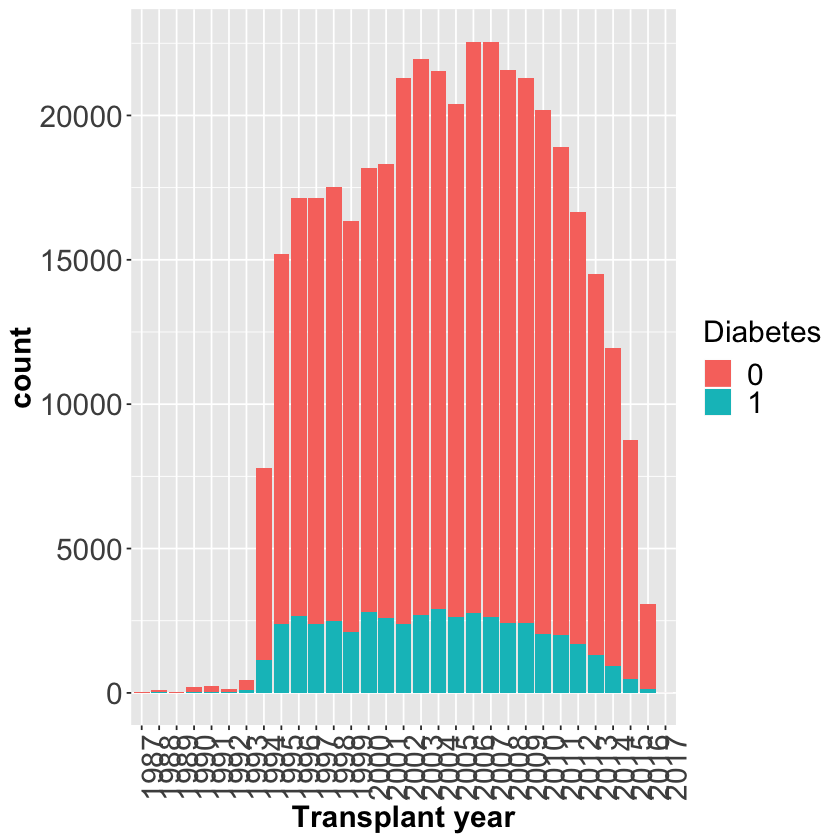

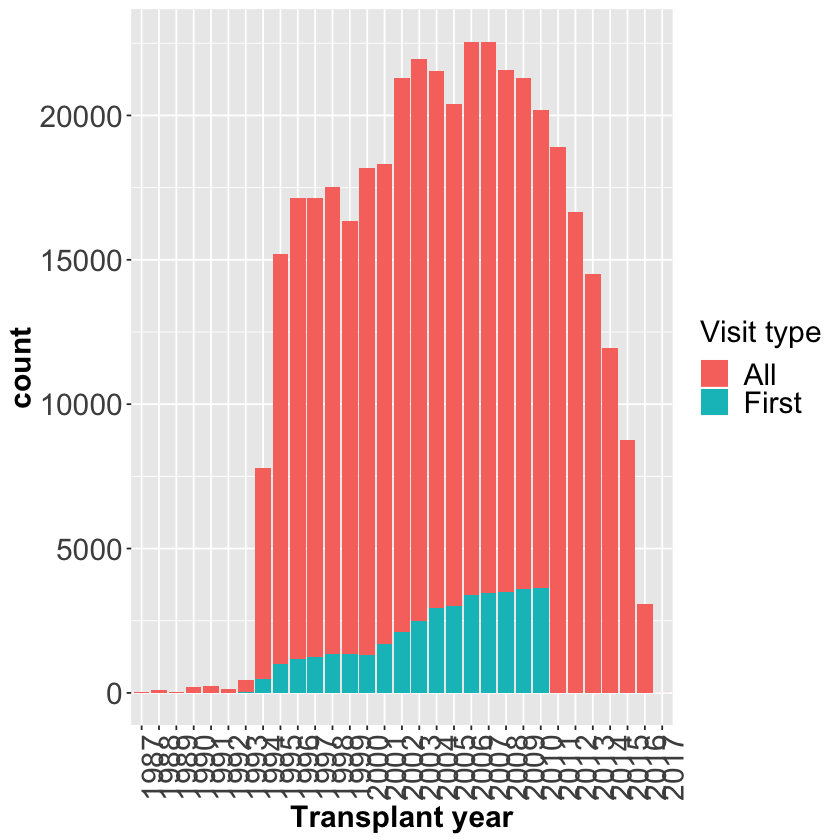

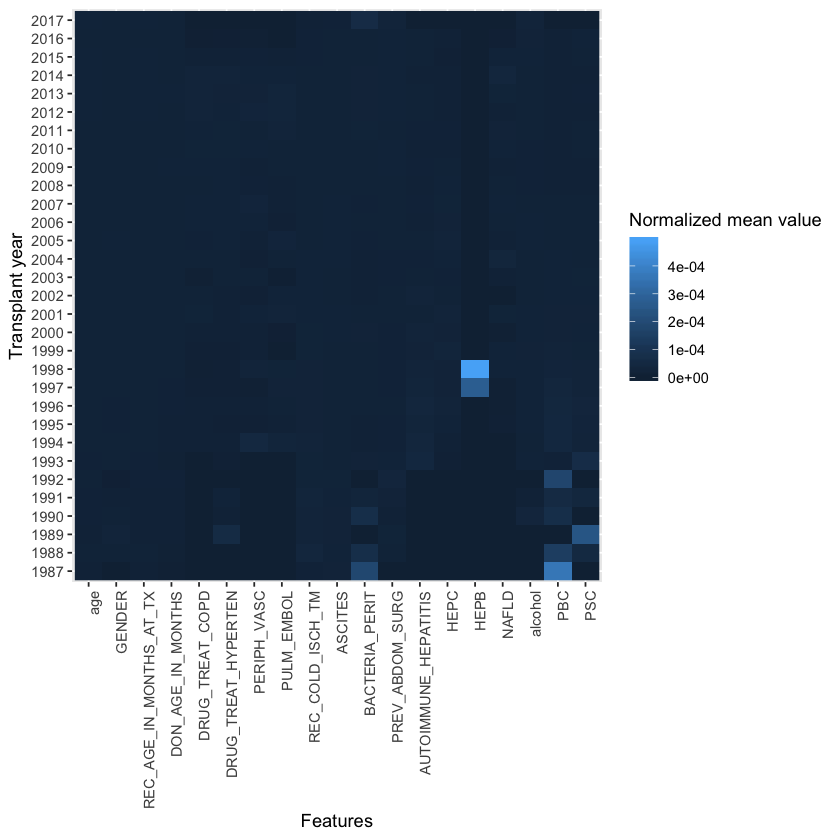

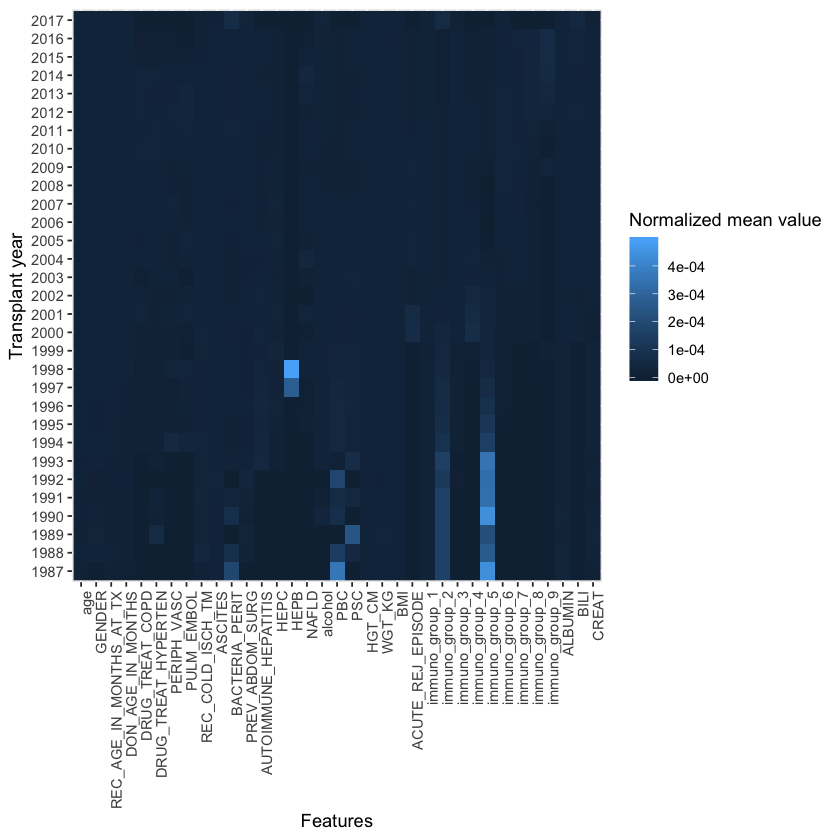

In [1]:
# Plot figures corresponding to the data
library("ggplot2")
library("dplyr")
library("foreach")
library("data.table")


include_lab = T
include_ethdon = F
num_lag = 0
eq_train_ratio = F
train_thresh_year = 1990
cutoff_visit = T

commandArgs = function(...) c(include_lab, include_ethdon, num_lag, eq_train_ratio, train_thresh_year, cutoff_visit)
source("R/prep_exp.R")

# Plot diabetes ratio across transplant years
p = ggplot(df, aes(transplant_year, fill = factor(is_diab)))
print(p + geom_bar(position = "stack") + labs(fill = "Diabetes") + 
  theme(axis.text = element_text(size=18), axis.title=element_text(size=18,face="bold"), 
        axis.text.x = element_text(angle=90, hjust=1), legend.text=element_text(size=18),
        legend.title=element_text(size=18)) + xlab("Transplant year"))


# Plot distribution of first visits across transplant years
df$first_visit = with(df, { (transplant_year < 2011) & 
    ((transplant_year < 2000 & time_since_transplant == 0.5) | 
       (transplant_year >= 2000 & time_since_transplant == 0))})

df = group_by(df, TRR_ID) %>% mutate(last_visit = time_since_transplant == 
                                                       max(time_since_transplant)) %>% as.data.frame()

df = mutate(df, visit_type = if_else(transplant_year >= 2011, 0, if_else(first_visit, 1, 0)))

p = ggplot(df, aes(transplant_year, fill = factor(visit_type)))
print(p + geom_bar(position = "stack") + scale_fill_discrete(name = "Visit type", 
                                                       labels = c("All", "First")) + 
  xlab("Transplant year")  + theme(axis.text = element_text(size=18), axis.title=element_text(size=18,face="bold"), 
                                 axis.text.x = element_text(angle=90, hjust=1), legend.text=element_text(size=18),
                                 legend.title=element_text(size=18)) + xlab("Transplant year"))


# Plot feature distribution across transplant years or visit year
df = filter(df, (time_since_transplant == 0 & transplant_year >= 2000) | 
              (time_since_transplant == 1 & transplant_year < 2000))
norm_df = t(t(df[, cov_cols])/colSums(df[, cov_cols]))
df2 = cbind(df[, c("transplant_year", "TRR_ID")], norm_df)
df2_melt = melt(unique(df2[, c("transplant_year", "TRR_ID", cov_cols)])[, c("transplant_year", cov_cols)], 
           c("transplant_year"))
df3 = group_by(df2_melt, transplant_year, variable) %>% summarize(avg = mean(value))
p = ggplot(df3, aes(variable, transplant_year)) + geom_raster(aes(fill=avg))
p + xlab("Features") + ylab("Transplant year") +  scale_fill_continuous(name = "Normalized mean value") +
  theme(axis.text.x = element_text(angle=90, hjust=1))#, axis.text = element_text(size=18), axis.title=element_text(size=18,face="bold")) 

df = filter(df, (time_since_transplant == 0 & transplant_year >= 2000) | 
              (time_since_transplant == 1 & transplant_year < 2000))
norm_df = t(t(df[, c(cov_cols, timedep_cols)])/colSums(df[, c(cov_cols, timedep_cols)]))
df2 = cbind(df[, c("transplant_year", "TRR_ID")], norm_df)
df2_melt = melt(unique(df2[, c("transplant_year", "TRR_ID", c(cov_cols, timedep_cols))])[, c("transplant_year", c(cov_cols, timedep_cols))], 
                c("transplant_year"))
df3 = group_by(df2_melt, transplant_year, variable) %>% summarize(avg = mean(value))
p = ggplot(df3, aes(variable, transplant_year)) + geom_raster(aes(fill=avg))
print(p + xlab("Features") + ylab("Transplant year") +  scale_fill_continuous(name = "Normalized mean value") +
  theme(axis.text.x = element_text(angle=90, hjust=1)))#, axis.text = element_text(size=18), axis.title=element_text(size=18,face="bold")) 



Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt



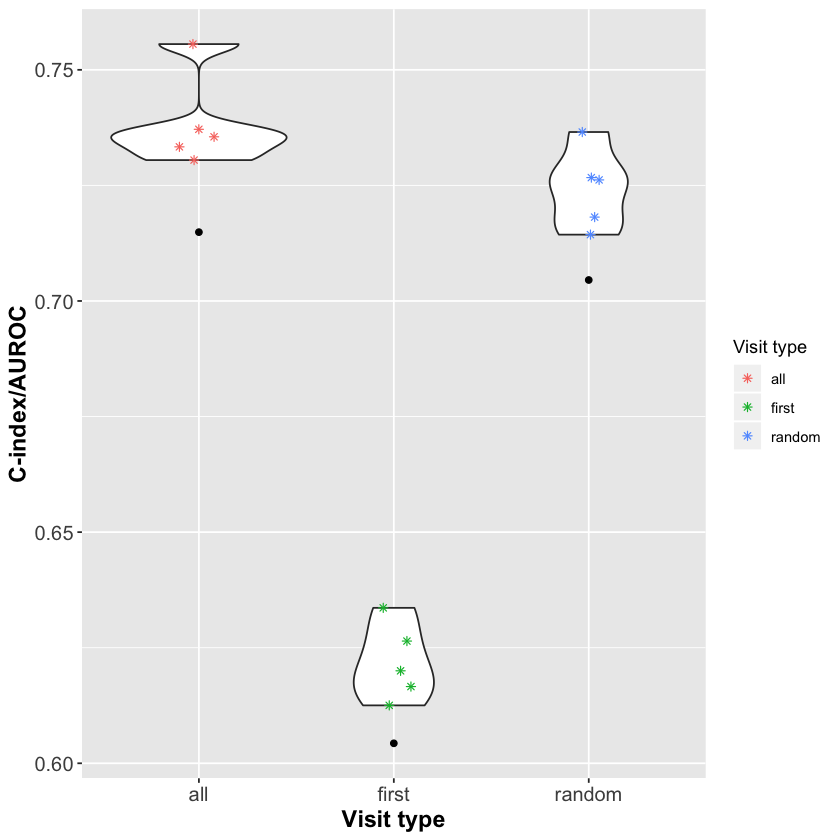

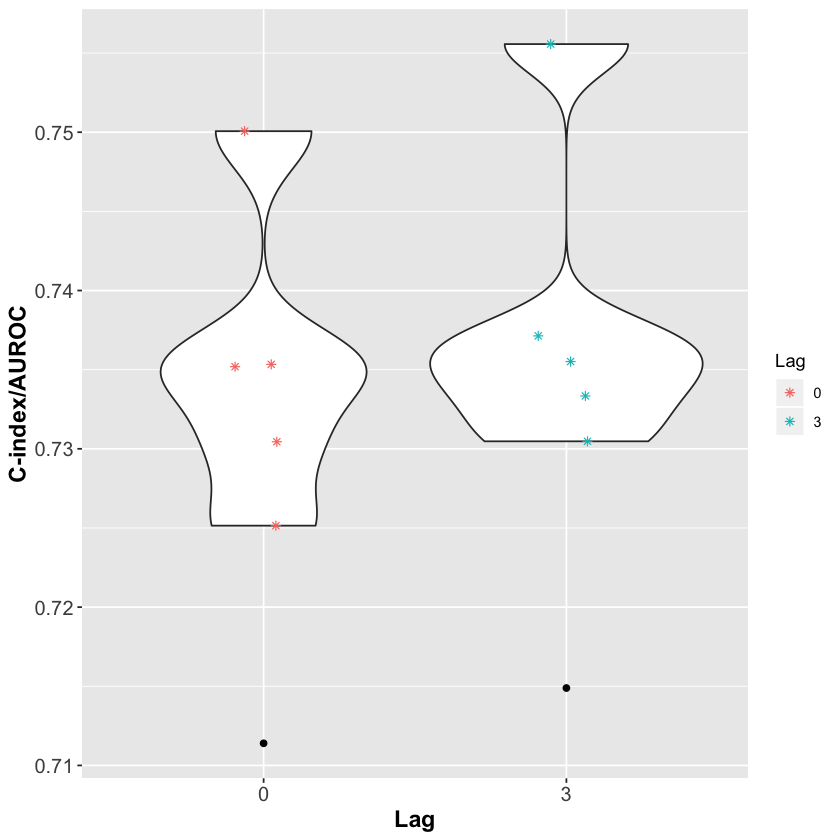

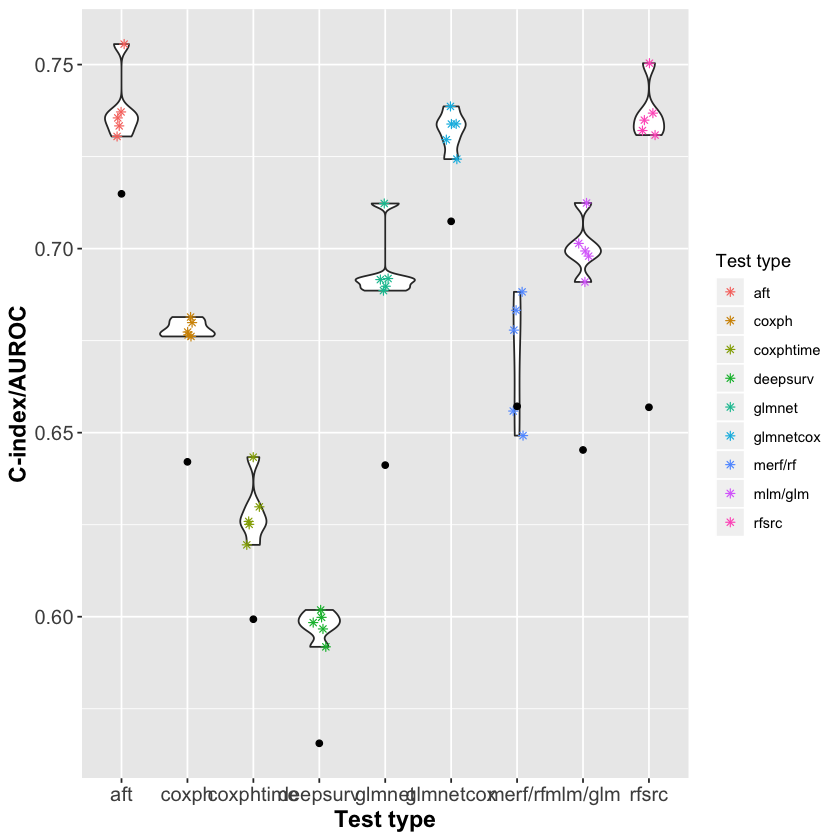

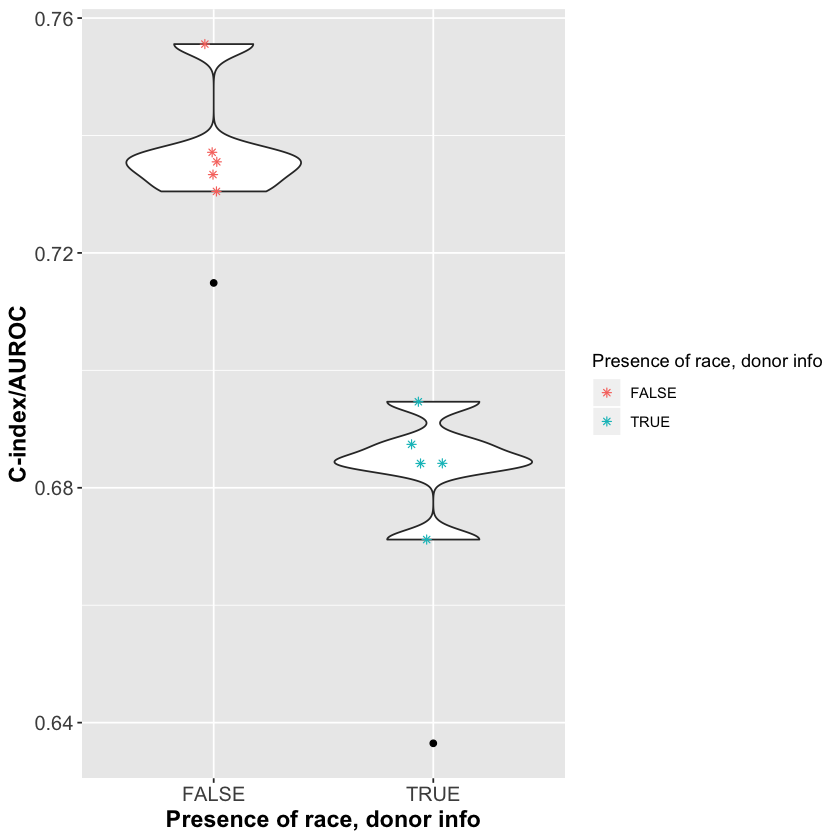

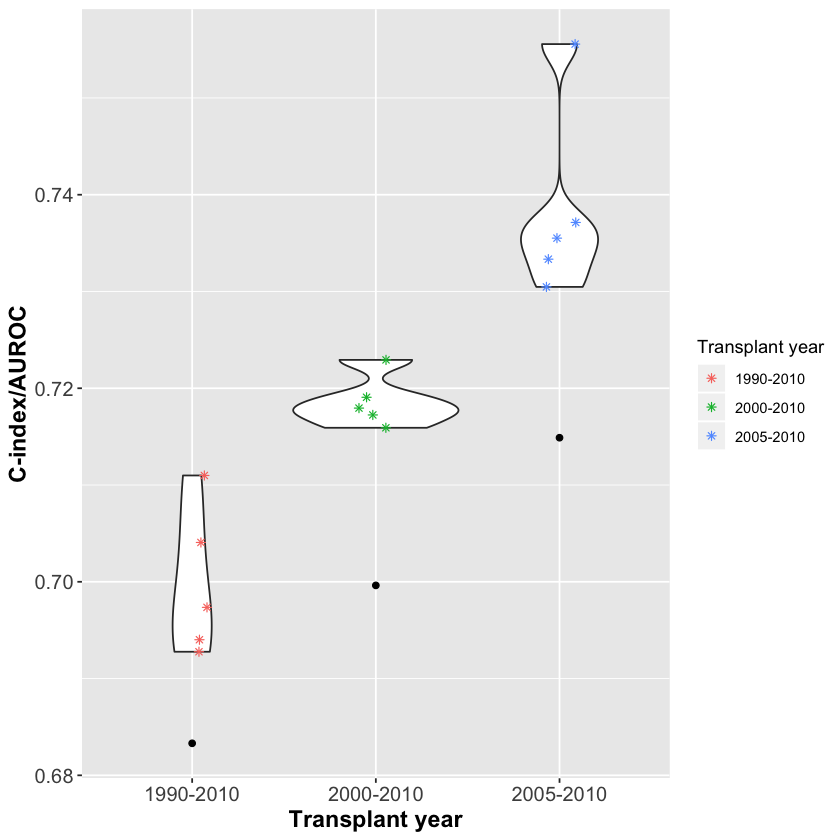

In [2]:
# Experiments are done by running conduct_exp_r.sh and conduct_exp_py.sh.
# Since we tried different configurations of training, it resulted in hundreds of different training settings
# conduct_exp_r.sh: script to kick off all R jobs into cluster 
# conduct_exp_py.sh: script to run all python jobs in a for loop
#
# Both scripts can be easily modifiable to run all the jobs into cluster or sequentially 
# by changing qsub to R/python and vice versa.
#
# Each job run will output text file and rds/pickle file that contains the final trained model. 
# The output text file summarizes the performance for that job. 
# These text files can be concatenated with each other into 1 giant csv file, e.g. performance.csv.


library(reshape2)

perf = read.csv("performance.csv")

# Collect information of best performing model within each setting, 
# e.g. which model perform best among those trained with visit_type == "first" or "all" or "random"
best_models = foreach (col = c("visit_type", "include_hist", "test_type", "include_ethdon", "transplant_year_subset"),
                  .combine = rbind) %do% 
  {
  foreach (item = unique(perf[, col]), .combine = rbind) %do% {
    if (!is.na(item)) {
      df = filter(perf, !!rlang::sym(col) == item) %>% filter(test == max(test, na.rm = T))
      return(cbind(col, item, df[1, ]))
    }
  }
}
colnames(best_models) = c("category", "group", colnames(perf))

# Plot the validation and test performance
df = select(best_models, category, group, test, val1, val2, val3, val4, val5)
df.m = melt(df, c("category", "group"))
df.m$variable = as.character(df.m$variable)
df.m$variable[grepl("val", df.m$variable)] = "val"
df.m$value = as.numeric(df.m$value)

for (cat in unique(df.m$category)) {
  df2 = filter(df.m, category == cat)
  if (cat == "test_type") # Change the levels of the factor to make it easier to see
      df2$Group = factor(df2$group, c("aft", "coxph", "coxphtime", "glmnetcox", "deepsurv", 
                                      "rfsrc", "mlm/glm", "glmnet", "merf/rf"))
    
  p = ggplot() + geom_violin(aes(group, value), data = filter(df2, variable == "val")) +
    geom_jitter(aes(group, value, color = factor(group)), shape = 8,
                height = 0, width = 0.1, data = filter(df2, variable == "val")) + 
    geom_point(aes(group, value), data = filter(df2, variable == "test")) +
    xlab(cat) + ylab("C-index/AUROC") + 
    theme(axis.text = element_text(size=12), axis.title=element_text(size=14,face="bold"))   + 
    scale_color_discrete(name = cat)
  print(p)
}

best_model = select(best_models, -category, -group) %>% filter(test == max(test, na.rm = T)) %>% unique


In [3]:
# Performance on local data
# Get performance on local data for R models
commandArgs = function(...) c("local_perf_R.csv")
source("R/eval_local.R")

local_perf_R = read.csv("local_perf_R.csv", header = T, stringsAsFactors = F)
cols = colnames(local_perf_R)

# Get performance on local data for python models
library(reticulate)
py_run_file("python/eval_local_deepsurv.py") # Save performance to local_perf_deepsurv.txt
py_run_file("python/eval_local_merf.py") # Save performance to local_perf_merf.txt

merf = read.csv("local_perf_merf.txt", header = F, stringsAsFactors = F)
deepsurv = read.csv("local_perf_deepsurv.txt", header = F, stringsAsFactors = F)

num_col = ncol(merf)
colnames(merf) = cols[1:num_col]
df = rbind(rbind(local_perf_R[, 1:num_col], merf[, 1:num_col]), deepsurv[, num_col])

# Print best performing model
print(filter(df, cindex.auroc == max(cindex.auroc, na.rm = T)))

# Print how best performing model from SRTR perform on local data
print(filter(df, train_thresh_year == best_model[1, "Transplant.year"], test_type == best_model[1, "Test.type"], 
             visit_type == best_model[1, "Visit.type"], lag == best_model[1, "Lag"]))

  train_thresh_year test_type visit_type lag cindex.auroc  nrow
1              2005    glmnet     random   0     0.853179 13989
  train_thresh_year test_type visit_type lag cindex.auroc  nrow
1              2005       aft        all   3    0.7827082 13989
